# Wavelet-based image compression with different Wavelet transforms
This tutorial explores the coding efficiency associated with three well-known Discrete Wavelet Transforms (DWTs) when plugged in a simple, yet practical image coding scheme. The three DWTs considered are the Haar, LeGall 5/3 and Cohen Daubechies and Feauveau (CDF) 9/7. All three transforms are well-known and studied in the literature being the former the simplest Wavelet with some merit for image compression whilst the latter two have been adopted in the first part of the JPEG 2000 image compression format, technically known as ISO/IEC 15444-1, ITU-T [T.800](https://www.itu.int/rec/T-REC-T.800-201906-I/en). Rather than studying the coding efficiency of these three Wavelet transforms in a JPEG 2000 compliant image codec, we opt to implement a simpler compression format hereafter denoted as Simple Wavelet-based Image Coding (SWIC). Such an approach will have the advantage to show the reader how to implement all these transforms in the Python programming language and using the [*lifting scheme*](https://en.wikipedia.org/wiki/Lifting_scheme) as well as all the codec's modules such as quantisation and entropy coding. Conversely, appraising the coding efficiency of all these transforms in a JPEG 2000 compliant workflow, would have required a significant implementation effort to the reader as well as to also focus on aspects, such as *TagTrees* which are not relevant to aim of this tutorial.

In the following we will recall some fundamental results from the Wavelet transform and multiresolution analysis theories, which will lead to introduce the three DWTs studied. The focus will then move to introduce the SWIC format and the associated image encoder and decoder, so that the coding efficiency can be evaluated on some test images. The summary of the theorethical results presented here doesn't pretend to be exhaustive: plenty of good textbooks and tutorial papers have been written on the subject of Wavelet transformation. The reader is therefore advised to consult the following good initial references:
 * David S. Taubman and Micheal W. Marcellin, "JPEG 2000: Image compression fundamentals, standards and practice", Kluwer Academic Press, 773 pages, 2002.
 * Khalid Sayood, "Introduction to data compression", Morgan Kaufmann Publisher, 680 pages, 3rd edition, 2006.
 * Rafael C. Gonzalez and Richard E. Wood, "Digital image processing", Pearson, 976 pages, 3rd edition, 2007.

## Introduction and preliminary remarks
The Wavelet transform was defined to represent/analyse signals which are space and/or time variant: Fourier-based transforms such as the discrete cosine transform only provide a global view of their frequency spectrum without any local information. As an example, imagine an audio signal with fundamental harmonic $\omega_0$  which has another harmonic $\omega_1 = 2\cdot\omega_0$ that kicks in after at a given point in time. Fourier analysis will only tell that there are two components at frequency $\omega_0$ and $2\cdot\omega_0$ but it will not tell at which exact time they appear.

### Wavelet and multi resolution analysis
The main idea behind Wavelet transformation is to represent a signal $f(\cdot)$ as a linear combination of the so-called *Wavelet mother* $\psi$, properly scaled and translated along the original signal's support. Expressing a function as a combination of a basis $\psi$ at different scales is formalised by the Multi Resolution Analysis ([MRA](https://en.wikipedia.org/wiki/Multiresolution_analysis)) theory - introduced by Stephan Mallat at the end of the eighties - which provides the right mathematical framework to make sure the dilations and translations of $\psi$ converge to $f(\cdot)$ in Hilbert's sense, i.e. the dot product has $L^2$-norm.

Essentially a MRA is an ensemble of nested subspaces $V^{(k)}$ of $L^2$ functions with $k\in \mathbb{Z}$ and whereby the resolution increases with negative values of $k$. To qualify as MRA, the sequence of subspaces should also provide a *scaling function* $\varphi(\cdot) \in V^{(0)}$ such that its translations defines an othonormal basis in $V^{(0)}$. Due to the nested nature of an MRA, one can express $\varphi(\cdot)$ as a linear combination of functions $\varphi^{-1}_n(\cdot)$ in $V^{-1}$ as follows:

$$
\varphi(t) = \sum_{n=-\infty}^{\infty}g_0(n)\cdot\varphi^{-1}_n(t) = \sqrt{2}\sum_{n=-\infty}^{\infty}g_0(n)\cdot\varphi(2\cdot t - n)
$$

where we have assumed that our MRA is defined over time-based signals with independent variable $t$. Considering an orthonormal basis for $V^0$, that is $\left\{\varphi_n^0\right\}_{n\in\mathbb{Z}}$ and using the relation above, one can show that:

$$
\delta(n) = \langle\varphi^{(0)}_0,\varphi^{(0)}_n\rangle = \ldots = \sum_i g_0(i)\cdot g_0(i - 2n),
$$

meaning that the sequence of coefficients $g_0(n)$ has unit norm and it is orthogonal to all its 2-translates. Such a property is the one required in a [*two-channel subband transform*](https://ccrma.stanford.edu/~jos/sasp/Two_Channel_Critically_Sampled_Filter.html) filter bank for the low-pass synthesis filter $g_0(n)$. This consideration shows the relationship between MRA and two channel subband transforms with perfect reconstruction. Following the same rationale, it can also be shown that the synthesis high-pass filter of the same two channel subband transform is instead associated with the Wavelet function $\psi(t)\in W^{(0)}$ where $W^{(0)}$ is defined as the [orthogonal complement](https://en.wikipedia.org/wiki/Orthogonal_complement#:~:text=In%20the%20mathematical%20fields%20of,perp%2C%20short%20for%20perpendicular%20complement.) of $V^{(0)}$ in $V^{(-1)}$. The relationship between two channel subband transform filter banks, scaling and Wavelet functions leads to define these two latter functions via the filter's impulse responses. As an example consider the synthesis impulse response of the low-pass filter $g_0$. It can be shown that in the Fourier domain:

$$
\hat{\varphi}(\omega) = \prod_{i=1}^{\infty}\hat{m}_0\left(\frac{\omega}{2^i}\right),
$$

with $\hat{m}_0(\omega) = \frac{1}{\sqrt{2}}\cdot\hat{g}_0(\omega)$ and $\hat{\varphi}(\omega)$ being the Fourier spectrum of the synthesis filter's scaling function.

### Discrete Wavelet transform as a cascade of filter banks
The relationship between MRA and channel subband transforms gives a convenient way to define and indeed implement the DWT. In fact, considering the analysis part of the filter bank, the different nested subspaces define the so-called decomposition levels which can be derived as depicted in the following figure:

<img src="dwt-block-schema.png" alt="Discrete Wavelet transform definition via cascade of filter banks" width="1100"/>

Where $H_0$ and $H_1$ denote the low- and high-pass analysis filters of the two channel subband filter bank whilst $L$ is the number of resolution (or decomposition) levels. The inverse of the DWT is constituted by a cascade of filter banks having the synthesis filters $G_0$ and $G_1$. Worth noting the bold font type used for variables $z$ and $n$, to indicate that these quantities may be vectors in case filters $H_0$ and $H_1$ can operate on vectors rather than scalars. For the cascade block scheme above, each decomposition level $l$ would lead to two set of values $y_0^{(l)}$ and $y_1^{(l)}$, which can be then quantised and entropy encoded as we shall see later. In this tutorial we consider 2D signals, i.e. images where the filtering is firstly applied along rows and then columns. Given these two directions and the two filters $H_0$ and $H_1$, there would be four subbands (i.e. set of transform coefficients) resulting from the filtering operations:

 * **LL** = Low-pass filtering along both rows and columns (low resolution approximation of the input image)
 * **HL** = High-pass filtering along rows and low-pass filtering along columns (vertical details/edges)
 * **LH** = Low-pass filtering along rows and high-pass filtering along columns (horizontal details/edges)
 * **HH** = High-pass filtering along both rows and columns (diagonal details/edges)

The LL subband is then used to repeat the filtering operations until a given number of decomposition levels is obtained. The following picture depicts three levels of decompositions resulting from the DWT. Such an arrangement is also denoted as dyadic (a.k.a. Mallat) packing arrangement.

<img src="image-dwt-example.png" alt="Example of three levels of decomposition for a DWT applied over an image" width="400"/>

Being the LL subband a low resolution approximation of the input image, the reader can easily realise how the DWT naturally offers the feature of ***spatial scalability***, meaning that by decoding a subset of subband coefficients one can obtain an image whose spatial resolution is lower than the original one. As example, consider $L$ decomposition levels applied over an input image with $W\times H$ columns and rows, respectively; by sending the LL subband only, the decoder will be able to decode an image with resolution $\frac{W}{L}\times\frac{H}{L}$. The more subbands are sent for each decomposition level, the higher the spatial resolution of the image decoded will be. Spatial scalability is an attractive feature, especially when a transmitter needs to serve different receivers, each with their display capabilities. Besides the use of DWT, spatial scalability can also be achieved by encoding the input image at the lowest resolution and then sending the residuals associated with the higher resolution image and the compressed one, upsampled at the same spatial resolution. Such an approach is the one followed in all scalable extensions of video coding standards specified by the MPEG-x and ITU-T H.26x families and resembles a [Laplacian Pyramid](https://en.wikipedia.org/wiki/Pyramid_(image_processing)). Still on the subject of Laplacian Pyramid, worth mentioning the MPEG-5 Low Complexity Enhancement Video Coding ([LEVC](https://www.lcevc.org/)) standard which assumes a two level pyramid and specifies only how the enhancement residual information is compressed, leaving the codec's designer the liberty to select the compression format for the base layer (i.e. the bitstream associated with the lowest image resolution).
As a final remark, it is worth recalling that the relationship between subband channel transforms and MRA is not bidirectional: i.e. not all pairs of low- and high-pass filters - which satisfy the perfect reconstruction condition for a two channel subband transform - would lead to a scaling and Wavelet functions for a MRA. The opposite is always true, i.e. given a MRA framework, a two channel subband transform filter bank can be derived to implement the associated Wavelet.

## Wavelet kernels considered
As mentioned earlier, three different Wavelet transforms are considered in this tutorial so to appraise their coding efficiency when plugged into an image codec complaint with the SWIC format. In the following the formulae for each transform are reported assuming that each one of is implemented using the *lifting technique*, which simplifies the implementation of a given Wavelet kernel by (asymptotically) a factor of [two](https://9p.io/who/wim/papers/factor/factor.pdf).

### Haar Wavelet
This is the simplest Wavelet transform which can be thought for the purpose of signal compression. The low- and high-pass subbands are defined as the arithmetic average and difference between two adjacent samples. Accordingly, its scaling function is simply given by:
$$
\varphi(t) = 
\left\{\begin{array}{ll}
1 & 0 \leq t < 1\\
0 & otherwise \\
\end{array}
\right..
$$

Typically this Wavelet is given by its matrix and orthornormal formulation:

$$
\left|\begin{array}{c}
    y_0\\
    y_1\\
\end{array}\right| = \frac{1}{\sqrt{2}}\cdot
\left|
    \begin{array}{cc}
        1 & 1 \\
        1 & -1\\
    \end{array}
\right|\cdot
\left|\begin{array}{c}
    x_0\\
    x_1\\
\end{array}\right|,
$$
being $\mathbf{Y} = (y_0, y_1)$ the output coefficients and $\mathbf{X} = (x_0, x_1)$ the input samples with index 0 associated with even positions and index 1 with the odd ones. The formulation used in this tutorial, hence in the SWIC format is obtained by multiplying the equation above by $\frac{\sqrt{2}}{\sqrt{2}}$ and separating the rows for indexes 0 and 1:
$$
\left|\begin{array}{c}
    y_0\\
    y_1\\
\end{array}\right| = 
\left|\begin{array}{c}
    \frac{1}{2}\cdot(x_0 + x_1)\\
    (x_1 - x_0)\\
\end{array}\right|.
$$

As mentioned already, we would implement this transform using the lifting scheme which would result in its forward and inverse formulations:
$$
\large
\begin{array}{c}
y_1 = x_1 - x_0\\
y_0 = x_0 + \lfloor\frac{y_1 + 1}{2}\rfloor.
\end{array} , 
\begin{array}{c}
x_0 = y_0 - \lfloor\frac{y_1 + 1}{2}\rfloor\\
x_1 = y_1 + x_0.
\end{array}
$$

We notice that the formulation above maps integer sample values into integer coefficients values and doesn't increase the input's bit depth. This property is well suited in hardware implementations where increasing the bit depth of data registers can be expensive. We note however that the original formulation would increase by one bit on each decomposition level of the 1D transform and thus by two bits in the case of 2D transformation. The Python implementation provided of the Haar Wavelet also implements such a bit depth expansion version for the reader's reference, although it will not considered in the SWIC format.

### LeGall 5/3 Wavelet
This Wavelet transform is adopted in the JPEG 2000 standard for the reversible (i.e. lossless) processing and it has been defined by finding a linear phase spline-based filter which converges to $\hat{\varphi}(\omega) = \prod_{i=1}^{\infty}\hat{m}_0\left(\frac{\omega}{2^i}\right)$. The analysis kernels $H_0(z)$ and $H_1(z)$ are given by:
$$
\large
\begin{array}{l}
H_0(z) = -\frac{1}{8}z^{-2} + \frac{1}{4}z^{-1} + \frac{3}{4} + \frac{1}{4}z - \frac{1}{8}z^2\\
H_1(z) = -\frac{1}{4}z^{-1} + \frac{1}{2} - \frac{1}{4}z
\end{array}.
$$

Conversely, the synthesis filters are given by:
$$
\large
\begin{array}{l}
G_0(z) = \frac{1}{2}z^{-1} + 1 + \frac{1}{2}z\\
G_1(z) = -\frac{1}{4}z^{-2} - \frac{1}{2}z^{-1} + \frac{3}{2} - \frac{1}{2}z - \frac{1}{4}z^2
\end{array}.
$$

The JPEG 2000 standard specifies the subband gain factor to be equal to one so that the coefficients are guaranteed to fit in the nominal range $[-\frac{1}{2},\frac{1}{2}]$, i.e. no scaling is applied on the input values.

### CDF 9/7 Wavelet
The last Wavelet considered in this tutorial is the one associated with the irreversible (i.e. lossy) processsing as specified in Part 1 of the JPEG 2000 standard. Such a transform has filter kernels of length 9 and 7 for the analysis part, which are defined as:

$$
\large
\begin{array}{l}
H_0(z) = a + b\cdot(z + z^{-1}) - c\cdot(z^2 + z^{-2}) - d\cdot(z^3 + z^{-3}) + e\cdot(z^4 + z^{-4})\\
H_1(z) = \tilde{a} - \tilde{b}\cdot(z + z^{-1}) - \tilde{c}\cdot(z^2 + z^{-2}) + \tilde{d}\cdot(z^3 + z^{-3})
\end{array}.
$$

The filter kernels for this Wavelet are defined using the same spline-based method as in the LeGall's case. The coefficients $a,\ldots,\tilde{d}$ are given as the numerical evaluation of the roots for the polynomials associated with the Fourier transform of the analysis and synthesis impulse responses. As in the case of the LeGall 5/3 Wavelet, also here the JPEG 2000 standard specifies subband gain factor equal to one to keep the coefficients in the nominal range $[-\frac{1}{2},\frac{1}{2}]$.

## The SWIC format
We describe in a greater detail the main coding tools composing the Simple Wavelet-based Image Coding (SWIC) format. SWIC has been designed to be easy to implement but at the same time to offer a few features characterising practical image compression schemes based on the DWT. For the reasons which will be clarified in the following, some tools have also been designed to be easy to implement on general software computing commodities so the throughput of the format is maximised. The following restrictions are assumed:
 * Image chrominance subsampling equal to the 4:4:4 chroma format
 * Maximum number of image colour channels equal to three
 * Image colour space with [ITU-R BT.709](https://www.itu.int/rec/R-REC-BT.709-6-201506-I/en) colour primaries (although this is not strictly required)
 * Maximum five levels of Wavelet decomposition
 * DWT performed according to the dyadic (a.k.a. Mallat) decomposition, whereby each decomposition level $l$ is half the size along rows and columns of $l-1$.

The following picture depicts the block schema of an encoder compliant with the SWIC format.

<img src="swic-encoder-schema.png" alt="Block schema of an encoder compliant with SWIC" width="1100"/>

The input image is assumed to be in the YCbCr colour space and any colour conversion from the RGB colour space is considered as a pre-processing step, hence outside the scope of the SWIC specification (depicted by the shaded block in the figure above). All image pixels are offset by the mid range value. This is the same operation also performed in any encoder compliant with the [JPEG Baseline profile](../jpeg/jpeg-baseline.ipynb) and guarantees that the **LL** subband (i.e. the subband obtained by low-pass filtering along the image rows and columns) has values lying in the same range and the other high frequency subbands. The remaining coding tools are detailed in the ensuing subsections.

### Discrete Wavelet transform
As already mentioned, three different DWT types are specified. The LeGall 5/3 and CDF 9/7 Wavelets extend the image boundaries using symmetric replication as specified in Annex F of the the [JPEG 2000](https://www.itu.int/rec/T-REC-T.800-201906-I/en) standard. We note that such a boundary extension is not required for the Haar Wavelet being a block-based transformation. The CDF 9/7 is implemented in floating point arithmetic with 64 bit precision. A more practical implementation would use integer arithmetic (e.g. 32 bit integers) and may be provided as future extension to this tutorial.

### Quantisation and reconstruction
Uniform quantisation is applied over all Wavelet subbands in each decomposition level. The quantiser used is the one specified by the [H.264/AVC](https://www.itu.int/rec/T-REC-H.264-202108-I/en) and [H.265/HEVC](https://www.itu.int/rec/T-REC-H.265-202108-I/en) standards whereby a Quantisation Parameter (QP) is defined over the integer range \[0, 51\] inclusive and is related via an exponential relationship with the quantisation step $\Delta$ approximated as follows:

$$
\large
\Delta = 2^{\left(\frac{QP-4}{6}\right)}.
$$

Essentially $\Delta$ doubles its value every increment by 6 of QP, that is: $\Delta(QP + 1) = \sqrt[6]{2}\cdot\Delta(QP)$. The exponential relationship is to guarantee the the quantisation parameter is matched to the rate via a logarithmic law, thus resembling a Peak-Signal-to-Noise-Ratio (PSNR) quality metric. Moreover, we notice that for QP values less than 4, $\Delta$ is less than one to allow that small magnitude coefficients will survive quantisation. This is a useful feature which can be exploited in practical encoders to adjust the rate control when operating at high coding rates: by inflating the value of transform coefficients, the encoder can meet the rate target without the need to resort to bitstream stuffing techniques. Still on the subject of having the quantisation easy to implement in software platforms, integer arithmetic is employed, whereas 14 bits are used for quantisation and 6 bits for reconstruction. Given an input transform coefficient $c$, the associated reproduction level is obtained as:

$$
\large
l = sign(c)\cdot\left(\left(|c|\cdot scale_q[QP \% 6] + \theta\right) >> \left(14 + QP/6\right)\right),
$$
where $>>$ denotes the binary shift operation, $\%$ is the remainder of the division by six, $|\cdot|$ is the absolute value operator, $\theta$ is the rounding offset given as $1 << \left(14 + QP/6 - 1\right)$, the division $QP/6$ is intended in integer arithmetic and $scale_q$ is a six entry array containing the result of the operation:

$$
\large
scale_q[i] = \left\lfloor\frac{\Delta(i)}{2^{14}}\right\rfloor,
$$

assuming $\Delta(0) \equiv 0.625$ and the remaining values are tabulated as follows:

index|0|1|2|3|4|5
-----|-----|-----|-----|-----|-----|-----|
$scale_q$|26214|23302|20560|18396|16384|14564|

Reconstruction uses six bit precision and provides the reconstructed coefficient $\hat{c}$ from the quantised level $l$ as:

$$
\large
\hat{c} = \left(l\cdot scale_r[QP \% 6] + \theta\right) >> (6 - QP/6),
$$

where $scale_r$ is a six entry array containing the scaling factors associated with the value of QP. Its values are listed in the following table:

index|0|1|2|3|4|5
-----|-----|-----|-----|-----|-----|-----|
$scale_r$|40|45|51|57|64|72|

We notice that the shift amount $6 - QP/6$ may become negative, leading to an inversion of the shift direction, i.e. from right to the left shift. In the latter case, the offset $\theta$ is set to zero, otherwise is set to $1 << (6 - QP/6 - 1)$.

The final aspect to address regarding quantisation is the fact that albeit the Wavelet implementations considered do not scale up the coefficients, it should be noted that each level of decomposition changes the range of the input value by requiring an additional bit for the HL and LH subbands and two bits for the HH subband. Such a gain factor could be accounted for in by decreasing the quantisation step according to the QP - $\Delta$ relationship described above. However, such an approach might lead to use frequently very low QP values (e.g. zero) when compressing at high coding rates. Accordingly, a different strategy is followed here whereby for each decomposition level of the Wavelet transform the HL and LH subbands are scaled up by 1 bit (i.e. their dynamic range is doubled), whilst the HH is scaled by two bits. During the reconstruction phase the bits added to the different subbands are removed through a right shift operation for each decomposition level. A more sophisticated way to take into account the gain across the decomposition levels when a specific Wavelet kernel is used, would consist in computing the $L^2$ norm of each low- and high-pass kernel and upsample their values on each decomposition level. Such an approach is the one suggested in Annex J.2 of the JPEG 2000 standard specification document.

### Subband splitting into code blocks
After quantisation, the transform coefficients are ready to be pushed through the entropy encoding stage. Both the encoding and decoding stages are intrinsically serial and, depending on the coding method selected, computationally demanding. To make the SWIC format practical to implement, especially on software platform, parallelisation should be supported during encoding and decoding. As such, subbands coefficients may be divided into blocks of fixed size which are independently encoded (and therefore can be independently decoded too). These blocks are denoted in the SWIC format as **code blocks** and are essentially the equivalent of code blocks in the JPEG 2000 standard except for the fact that they have square shape which is hard coded to $32\times32$ (unless a given subband has smaller size). Also, differently from the JPEG 2000 standard, SWIC specifies that a code block comprises all colour components of the current subband: this is because the only progression type supported in SWIC is resolution, subband and component. To make a code block independently decodable, its size needs to be communicated so that a practical decoder can start different parsing processes at different segments of the compressed bitstream. The SWIC format specifies two bytes as a prefix to the code block to signal its size (in byte units). The payload buffer of each code block is flushed at the end of the entropy encoding process, which implies that up to seven additional bits may be added to the final bitstream. Code blocks of each subband belonging to a given decomposition level are processed in raster scan order and the resulting encoded bits are organised as depicted in the following figure.

<img src="code-block-bitstreams.png" alt="Code block bistreams within a given Wavelet subband and decomposition level" width="800"/>

### Entropy encoding
Transform coefficients enclosed in each code block are then entropy encoded. Due to the type of subbands resulting from the DWT, one would expect the following:
 * Transform coefficients belonging to high frequency subbands (i.e. HL, LH and HH) are likely to have their values concentrated around zero, due to quantisation and their high-pass nature
 * Transform coefficients associated with the LL subband are more likely not to be quantised to zero due to the fact that they are associated with a low-pass approximation of the input image.

From the observations above, one would expect that a reasonable encoding scheme for transform coefficients belonging to the high frequency subbands might be the Run Length Encoding ([RLE](https://en.wikipedia.org/wiki/Run-length_encoding)) one where the values associated with the runs of zeros are encoded with [Golomb coding](../../entropy-coding/golomb-coding/golomb-coding-tutorial.ipynb), being this latter optimal for Geometrically distributed data such as the run of zeros . The values interrupting a run, will have to be encoded in some form. The considerations we are going to make for coefficients belonging to the LL subband will also apply to these non zero values.

For transform coefficients belonging to the LL subband, the most conservative choice might consist in applying Huffman coding. Doubtless a better coding efficiency may also be obtained if some form of residual encoding (e.g. Differential Pulse Code Modulation, DPCM) with sample-based prediction is adopted, most notably over screen content images where there are large image areas sharing the same pixel values (think about the connector lines in an engineering drawing). Huffman coding would require to train some tables and add support to the SWIC format to signal the tables in the bitstream. Moreover, sample-based prediction might be less efficient when compressing natural content, hence the SWIC format should let the encoder choose whether to use residual encoding with sample-prediction. For the sake of simplicity, the SWIC format uses Golomb coding over coefficients belonging to the LL subbands. As we mentioned in this [tutorial](../../entropy-coding/golomb-coding/golomb-coding-tutorial.ipynb), the Golomb parameter $k$ should be selected and ideally adapted throughout the encoding process. Still in name of simplicity (which is the last sophistication, according to Leonardo Da Vinci), the zero order exponential Golomb Coding proposed by Teuhola in 1978 are used to encode the absolute value of each transform coefficient. Using these codes any adaptation of the Golomb parameter $k$ is not required, hence any encoder and decoder implementation is pretty simple. Worth also recalling the good coding efficiency of exponential Golomb codes when the source has clustered values as well as the software friendliness associated with their implementation both at the encoder and decoder side. In fact, by using simple set bit instructions (e.g. count leading zeros, `clz`), the encoding and decoding processing can be efficiently achieved. For all subbands in a given decomposition level, fractional coding rate may be obtained if only the number of significant coefficients are encoded. Accordingly, for each code block the position of last coefficient different from zero is computed and, its value plus one, is entropy encoded using the same zero order exponential Golomb coding. By adding one to such a position, the total number of coefficients which are going to be entropy encoded is obtained. In case all coefficients are equal to zero a simple one value bit is written. The following pseudo code in Python, summarises the entropy encoding process for transform coefficients.

```Python
def write(value, number_of_bits) -> None:
    # Write the integer value using number_of_bits bits

def egc0(value) -> None:
    # Perform zero order exponential Golomb coding

def find_rlv_pairs(coefficients) -> List:
    # Find all run lenght value pairs within all coefficients
    # Return the results in a list where each entry is the run length and the value terminating it

def find_total_coefficients(coefficients) -> int:
    # Return the position of the last coefficient different from zero

total = find_total_coefficients(coefficients)
egc0(total)
if total:
    if is LL:
        for coeff in coefficients:
            egc0(abs(coeff))
            if coeff:
                sign_bit = 1 if coeff < 0 else 0
                write(sign_bit, 1)
    else:
        rlv_pair = find_rlv_pairs(coefficients)
        for pair in rlv_pair:
            egc0(pair.length)
            egc0(abs(pair.value))
            sign_bit = 1 if pair.value < 0 else 0
            write(sign_bit, 1)
```

Finally, we notice that the design of the SWIC format allows for encoders with focus on the coding efficiency to perform Rate Distortion Optimised Quantisation (RDOQ) at the different levels: at the coarsest the encoder can decide to set all coefficients in a code block to zero and transmit just the two bytes associated with the code block size. In a finer level RDOQ, the encoder can decide to leverage both on the coefficients value as well as on the value of the last significant coefficients, similarly to the algorithm described in this [tutorial](../jpeg/jpeg-rdoq.ipynb). Therefore, whilst rather simple, SWIC allows for easy implementation, particularly in software as well as to trade complexity for coding efficiency in practical implementations.

### Final packetisation
The bitstream associated with the different code blocks are written to a file according to the figure shown above. The whole bitstream is prefixed by some metadata which are essential to the decoder to perform its parsing operations. This information is organised in a syntax structure denoted in the SWIC format as Image Parameter Set (IPS). The following table lists the information conveyed by the IPS element in the same order it appears in the bitstream, along with the number of bytes used to represent it.

| IPS element | Total bytes |
| ----------- | ----------- |
| Symbolic header | 7 |
| Image width | 2 |
| Image height | 2 |
| Pixel bit depth and components | 1 |
| Decomposition levels and DWT type | 1 |
| QP value | 1 |

The symbolic header is defined as the string of ascii characters *SWIC-V1* and denotes the start of an image bitstream. If such a symbolic header is not found, the bitstream is not conformant to the SWIC format. Some information is packed together in a single byte. This is the case for pixels' bit depth and the number of colour components as well as the number of decomposition levels and the type of DWT kernel used. The information packing in a single byte is shown in the following figure.

<img src="metadata-packing.png" alt="Metadata packed into their bytes of the IPS" width="800"/>

## Software available
Being the SWIC format an ad-hoc codec designed specifically for this tutorial, the software which ships with it implements both the encoding and decoding processes so that the whole transcoding pipeline can be appraised, including the calculation of quality metrics such as the Peak-Signal-to-Noise-Ratio (PSNR). Accordingly, the following Python packages are provided:
 * `encoder.py`: Script implementing the whole SWIC compression process. A command line interface is also provided to specify the input image, output bitstream, as well as some encoding parameters such as number of decomposition levels, QP value, etc. The encoder also provides some additional information about the encoding process, e.g. the coding rate an input image has been compressed to. The command line option `--reconstructed` enables to save to an output file the image which will also be provided in output by the decoder. Such a feature is a handy functionality to debug whether the encoder and decoder are in sync, i.e. the produce the same decoded image.
 * `decoder.py`: Script implementing the whole SWIC decompression process. A command line interface is also provided to specify the input bitstream, output image and number of decomposition levels which should be decoded. This latter features will allow the user to appreciate the intrinsic scalability features of the DWT as well as the trade-off decoder's complexity vs final image quality.
 * `dwt.pt`: Python package providing methods to compute the forward and inverse DWT according to all the three kernel types studied in this tutorial, i.e. Haar, LeGall 5/3 and CDF 9/7.
 * `quantisation.py`: Python package implementing the quantisation and reconstruction processes, according to the quantiser specified in both the H.264/AVC and H.265/HEVC standards.
 * `bit_io.py`: Python package handling the bitwise writing and reading operations.
 * `ct.py`: Python package implementing forward and inverse transformations between the RGB and YCbCr colour spaces, according to both the [ITU-R BT.709](https://www.itu.int/rec/R-REC-BT.709-6-201506-I/en) and [ITU-R BT.601](https://www.itu.int/rec/R-REC-BT.601-7-201103-I/en) primaries.
 * `entropy.py`: Python package implementing the entropy coding specified in the SWIC format, i.e. zero order exponential Golomb coding and run length encoding.
 * `hls.py`: Python package implementing the writing and parsing of the high level syntax specified by SWIC; essentially this is writing and parsing of the IPS syntax element.

## Experiments and results
We are finally in a position to evaluate the coding efficiency associated with the three Wavelet kernels considered in this tutorial using the SWIC codec. To keep the experiments run time bounded to reasonable values, only small images will be considered. The reader can modify and/or extend the following Python cells to include more content and change any test condition. We would like to evaluate the coding efficiency of generic Wavelet-based image compression from the following different perspectives:
 * Rate distortion performance as a function of different decomposition levels
 * Rate distortion performance for the three different DWTs considered
 * Visual assessment of the block nature associated with the Haar Wavelet
 * Rate distortion comparison with the JPEG standard

The following subsections will presents the experimental results and related discussions. In the following, the objective image quality will always be measured by means of the PSNR along the luma component only and expressed in decibel units. Moreover, the coding rate  will be measured in terms of the bits per pixel (bpp). Three images will be used: the grey scale `cameraman`, the first frame of the well-known `foreman` video sequence in CIF resolution and finally the `peppers` image. All material has 8 bits per colour component and, unless grey scale, 4:4:4 chroma format is assumed. The following Python code cell loads the different packages required by the experiments along with some common definitions, including the well-known Bjontegaard Delta on the rate ([BD-rate](https://ottverse.com/what-is-bd-rate-bd-psnr-calculation-interpretation/)) metric, which quantifies the average coding rate penalty in percentages between two rate distortion curves assuming the same level of PSNR.

In [4]:
import numpy as np
import cv2
from ct import rgb_to_ycbcr_bt709, ycbcr_to_rgb_bt709

from encoder import swic_encoder
from decoder import swic_decoder
from dwt import DwtType
import os
import matplotlib.pyplot as plt
from nptyping import NDArray
from typing import Any

output_bitstream = "bitstream.swic"
fsize = 16

def bd_rate(ra: NDArray[(Any), np.float64], rt: NDArray[(Any), np.float64], da: NDArray[(Any), np.float64], dt: NDArray[(Any), np.float64]) -> float:
    log_ra = np.log(ra)
    log_rt = np.log(rt)

    pa = np.polyfit(da, log_ra, 3)
    pt = np.polyfit(dt, log_rt, 3)

    min_int = max(np.min(da), np.min(dt))
    max_int = min(np.max(da), np.max(dt))

    pa_int = np.polyint(pa)
    pt_int = np.polyint(pt)

    ia = np.polyval(pa_int, max_int) - np.polyval(pa_int, min_int)
    it = np.polyval(pt_int, max_int) - np.polyval(pt_int, min_int)

    diff_e = (it - ia) / (max_int - min_int)
    diff = (np.exp(diff_e) - 1) * 100

    return diff

### Coding efficiency and decomposition levels
We are interested in plotting the rate distortion curves of the SWIC codec over the `cameraman` picture when the Haar Wavelet is used and the number of decomposition levels spans the integer range \[1, 5\] inclusive. The expectation here is that the more decomposition levels, the better the coding efficiency given that:
 * More subbands will allow the entropy encoder to leverage more efficiently on tools such as run length encoding
 * Quantisation can do a better job with more levels, given that important image features will also be present at low resolutions

To assess our expectation in a numerical manner, the following Python code cell will run the SWIC encoder and decoder by varying the number of decomposition in the aforementioned range. The code also plots the rate distortion curves and the BD-rate, using the curve associated with the decomposition level equal to one as anchor. We remind the measuring convention for the BD-rate, whereby negative values are associated with coding rate savings, hence a better coding efficiency.

-----------------------
| Level | BD-rate [%] |
-----------------------
|     2 |      -30.76 |
|     3 |      -37.45 |
|     4 |      -38.47 |
|     5 |      -38.20 |


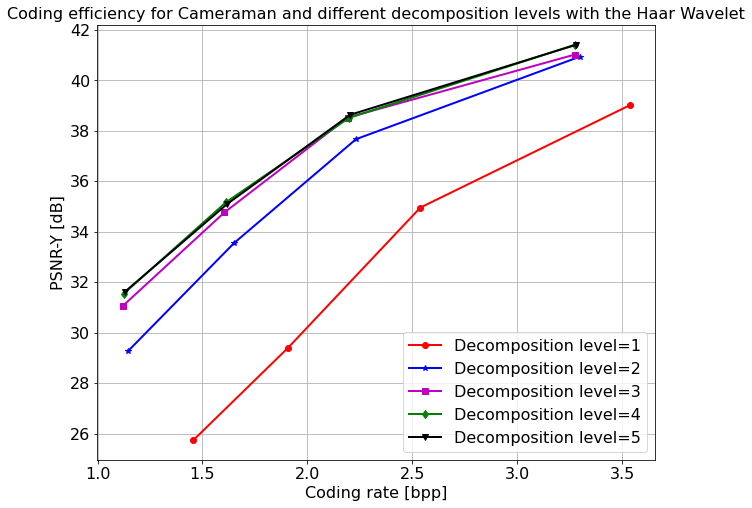

In [16]:
image_name = r"../../input-data/cameraman.tif"

levels = [1, 2, 3, 4, 5]
qp_test = np.array([22, 27, 32, 37], np.int32)
data_size = (len(levels), len(qp_test))
bpp = np.zeros(data_size)
psnr_y = np.zeros(data_size)


input_image = cv2.imread(image_name, cv2.IMREAD_UNCHANGED).astype(np.int32)
rows, cols = input_image.shape[0], input_image.shape[1]

for lev_idx, lev in enumerate(levels):
    for qp_idx, qp in enumerate(qp_test):
        # Encoding
        bytes, _ = swic_encoder(input_image, output_bitstream, qp, 8, lev, DwtType.Haar, False)
        bpp[lev_idx, qp_idx] = bytes * 8 / rows / cols

        # Decoding
        decoded_image = swic_decoder(output_bitstream, 0, False)
        mse = np.mean(np.square(input_image - decoded_image))
        psnr_y[lev_idx, qp_idx] = 10 * np.log10(255**2 / mse)

os.remove(output_bitstream)

plt.figure(figsize=(10, 8))

colours = ["r-o", "b-*", "m-s", "g-d", "k-v"]
for wt_idx, lev in enumerate(levels):
    plt.plot(bpp[wt_idx, :], psnr_y[wt_idx, :], colours[wt_idx], linewidth=2, label=f"Decomposition level={lev}")

plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.legend(fontsize=fsize)
plt.grid()
plt.title("Coding efficiency for Cameraman and different decomposition levels with the Haar Wavelet", fontsize=fsize)
plt.xlabel("Coding rate [bpp]", fontsize=fsize)
plt.ylabel("PSNR-Y [dB]", fontsize=fsize);

# Compute the BD-rate and print it out
header = "| Level | BD-rate [%] |"
print("-" * len(header))
print(header)
print("-" * len(header))
for lev in range(1, 5):
    current_bd_rate = bd_rate(bpp[0, :], bpp[lev, :], psnr_y[0, :], psnr_y[lev, :])
    print(f"| {lev+1:-5d} | {current_bd_rate:11.2f} |")


As we may notice from the rate distortion plot above there is a significant coding efficiency improvement already when more than one decomposition level is considered. Starting from three levels of decomposition the coding efficiency increment is less. Besides a better coding efficiency, we should also recall that more decomposition levels mean more flexibility in the spatial scalability dimension, resulting in a bitstream that can serve decoders with different display capabilities. The BD-rate values obtained, also report what can be observed from the graph above and hint that essentially using 4 or 5 decomposition levels do not change significantly the coding efficiency. The slight BD-rate drop associated with five decomposition levels may be due to numerical integration approximations in the BD-rate calculation rather than an actual efficiency penalty.

### Blocking artefacts for the Haar Wavelet
We mention already that the Haar Wavelet is indeed block-based transform, meaning that it can be computed by means of matrix multiplication as the Discrete Cosine Transform (DCT) in JPEG. Such a property turns the implementation of the Haar Wavelet pretty simple, without the need of signal extension, which translates into less memory and operation to perform in both hardware and software. The price to pay for such a low complexity of implementation is a reduced coding efficiency and the introduction of block-based compression artefacts, i.e. blocking.

We will now demonstrate such a problem over the `peppers` image which is compressed with the SWIC codec using five levels of decomposition and two different Wavelet Kernels: the Haar and LeGall 5/3. The value of the quantisation parameter is selected so that the coding rate attained by the codec using these two Wavelets is essentially the same. Also the coding rate is deliberately chosen to be low so that blocking artefacts can be seen more easily. Being the coding rate the same, both the objective and subjective quality can be appraised by measuring the PSNR (still on the luma component) and by visual inspection. The following Python code cell runs the SWIC codec using the two Wavelet kernels selected and then displays the obtained decoded images.

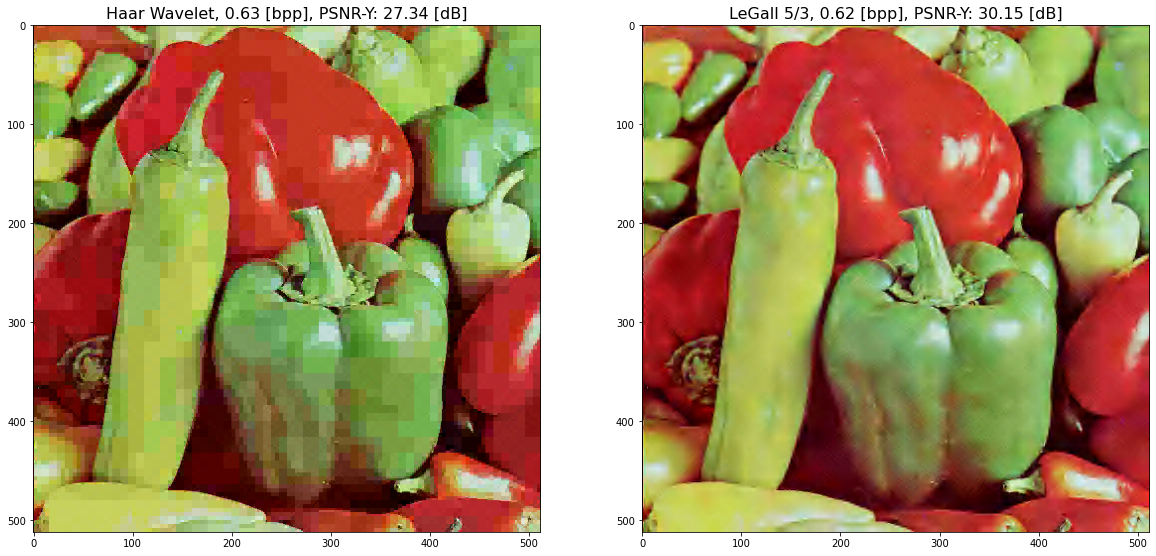

In [22]:
image_name = r"../../input-data/peppers.tiff"

qp_haar, qp_legall = 45, 44

input_image = cv2.imread(image_name, cv2.IMREAD_UNCHANGED).astype(np.int32)
red, green, blue = input_image[:, :, 2], input_image[:, :, 1], input_image[:, :, 0]
input_image = rgb_to_ycbcr_bt709(red, green, blue)
rows, cols = input_image.shape[0], input_image.shape[1]

# Transcoding with Haar transform
bytes_haar, _ = swic_encoder(input_image, output_bitstream, qp_haar, 8, lev, DwtType.Haar, False)
decoded_haar = swic_decoder(output_bitstream, 0, False)
mse_haar = np.mean(np.square(input_image[:, :, 0] - decoded_haar[:, :, 0]))
psnr_haar = 10 * np.log10(255**2 / mse_haar)

# Transcoding with LeGall 5/3 transform
bytes_legall, _ = swic_encoder(input_image, output_bitstream, qp_legall, 8, lev, DwtType.LeGall5_3, False)
decoded_legall = swic_decoder(output_bitstream, 0, False)
mse_legall = np.mean(np.square(input_image[:, :, 0] - decoded_legall[:, :, 0]))
psnr_legall = 10 * np.log10(255**2 / mse_legall)

str_haar = f"Haar Wavelet, {bytes_haar * 8 / rows / cols:.2f} [bpp], PSNR-Y: {psnr_haar:.2f} [dB]"
str_legall = f"LeGall 5/3, {bytes_legall * 8 / rows / cols:.2f} [bpp], PSNR-Y: {psnr_legall:.2f} [dB]"

# Prepare the decoded image for display
decoded_haar_rgb = ycbcr_to_rgb_bt709(decoded_haar[:, :, 0], decoded_haar[:, :, 1], decoded_haar[:, :, 2])
decoded_legall_rgb = ycbcr_to_rgb_bt709(decoded_legall[:, :, 0], decoded_legall[:, :, 1], decoded_legall[:, :, 2])

plt.figure(figsize=(20, 10))
plt.subplot(1,2,1), plt.imshow(decoded_haar_rgb.astype(np.uint8)), plt.title(str_haar, fontsize=fsize)
plt.subplot(1,2,2), plt.imshow(decoded_legall_rgb.astype(np.uint8)), plt.title(str_legall, fontsize=fsize);


As we may see from the images above, the coding rate is essentially the same, but the PSNR-Y values obtained differ by about 3 dB. It is well-known by image and video codec experts that the Just Noticeable Different (JND) associated with the average human observer is roughly 1 dB, hence here one would expect to see a noticeable difference between the images decoded. Indeed such a quality difference is pretty evident in the image associated with the Haar Wavelet having plenty of blocking artefacts and all colours washed out. The image associated with the LeGall 5/3 Wavelet is instead free from blocking artefacts and details are better preserved. At the low coding rate considered, some typical compression artefacts associated with DWTs such LeGall 5/3 and CDF 9/7 may be noted: colour bleeding and ringing around image edges appear. Also there is a noticeable amount of the so-called *mosquito* noise visible around sharp edges. Overall this experiment shows a clear win for DWTs whose scaling function is smoother than the Haar's. We will come back on this point later.

### Coding efficiency for the three different Wavelet transforms
This experiment will appraise the main goal set out at the beginning of this tutorial, i.e. quantify the coding efficiency associated with the different DWTs considered. Accordingly, the `foreman` image will be encoded with the SWIC codec using the Haar, LeGall 5/3 and CDF 9/7 Wavelets and five decomposition levels. The QP values are selected to span a wide range of coding rates, so a better and global picture of the coding efficiency can be constructed. As we did already, also the BD-rate will be measured, using the codec compressing with the Haar Wavelet are the reference. The following Python code cell runs the experiment and plots the rate distortion curves, along with the BD-rate values.

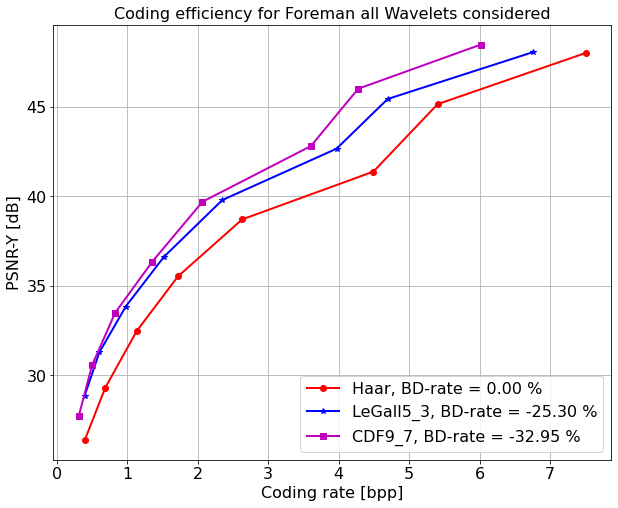

In [25]:
image_name = r"../../input-data/foreman_352x288_30Hz_8b_P444.yuv"

rows, cols = 288, 352
input_image = np.zeros((rows, cols, 3), np.int32)

with open(image_name, "rb") as fh:
    for comp in range(3):
        input_image[:, :, comp] = np.reshape(np.frombuffer(fh.read(rows * cols), dtype=np.uint8), (rows, cols)).astype(np.int32)

wavelet_type = [DwtType.Haar, DwtType.LeGall5_3, DwtType.CDF9_7]
qp_test = np.array([12, 17, 22, 27, 32, 37, 42, 47], np.int32)
bpp = np.zeros((len(qp_test), len(wavelet_type)))
psnr_y = np.zeros((len(qp_test), len(wavelet_type)))

bdr_values = np.zeros((len(wavelet_type)))

for wt_idx, wt in enumerate(wavelet_type):
    for qp_idx, qp in enumerate(qp_test):
        # Encoding
        bytes, _ = swic_encoder(input_image, output_bitstream, qp, 8, 5, wt, False)
        actual_bytes = os.stat(output_bitstream).st_size
        assert actual_bytes == bytes
        bpp[qp_idx, wt_idx] = bytes * 8 / rows / cols

        # Decoding
        decoded_image = swic_decoder(output_bitstream, 0, False)
        mse = np.mean(np.square(input_image[:, :, 0] - decoded_image[:, :, 0]))
        psnr_y[qp_idx, wt_idx] = 10 * np.log10(255**2 / mse)
    if wt != DwtType.Haar:
        bdr_values[wt_idx] = bd_rate(bpp[:, 0], bpp[:, wt_idx], psnr_y[:, 0], psnr_y[:, wt_idx])

os.remove(output_bitstream)

plt.figure(figsize=(10, 8))

colours = ["r-o", "b-*", "m-s"]
for wt_idx, wt in enumerate(wavelet_type):
    plt.plot(bpp[:, wt_idx], psnr_y[:, wt_idx], colours[wt_idx], linewidth=2, label=f"{str(wt)}, BD-rate = {bdr_values[wt_idx]:.1f}%")

plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.legend(fontsize=fsize)
plt.grid()
plt.title("Coding efficiency for Foreman all Wavelets considered", fontsize=fsize)
plt.xlabel("Coding rate [bpp]", fontsize=fsize)
plt.ylabel("PSNR-Y [dB]", fontsize=fsize);

As may be noted, the curve associated with the Haar Wavelet is far below in terms of PSNR values the the one for the LeGall and CDF Wavelets. This (expected) lower coding efficiency associated with the Haar Wavelet is constant over a wide range of coding rates. The reader is invited to try different images to appreciate how this trend translates. When considering spline-based Wavelet, we may note that the LeGall and CDF behave fairly similar at low coding rates but then differ at high rates with the CDF providing a better coding efficiency. In terms of BD-rate values, the primacy of the CDF Wavelet is also confirmed by the numbers, where an additional 7% can be saved on the coding rate when using this Wavelet.

One may wonder if it is possible to have an *a priori* idea on the coding efficiency associated with a given Wavelet kernel. For block-based transforms such as the DCT, we know that we can measure the so-called decorrelation efficiency, defined as the one complement of the ratio between the sum of absolute values for the covariance matrices of the DCT coefficients and image pixels. In this way, we know if a given transform is more or less efficient for compression based on its decorrelation capabilities. Conversely, such a decorrelation efficiency cannot be measured in general for the DWT, because it is not a block-based transform, hence the covariance matrix of the coefficients cannot be computed. We need therefore to resort to a different consideration which stems from the fact that a DWT is essentially a filter bank transform. Filtering involves the convolution operation which, aside from its mathematical definition, produces an output indicating how the shape of one input is modified by the other. For the DWT, one input is constituted by the reconstructed transform coefficients and the other is either the scaling function $\varphi$ or the Wavelet function $\psi$, depending on the subband type associated with the coefficients. In lossy compression the reconstructed coefficients differ by the original by a quantity $\delta(x,y)$ which can be modelled as a 2D white Gaussian noise. The spiky nature of the 2D quantisation error is going to be shaped (through the convolution operation) by the scaling and Wavelet functions during the inverse DWT. It is intuitive to realise that the smoother these two functions the less the quantisation error will be visible, hence the better the resulting reconstructed image quality. Along the same line of reasoning, the reader should be now convinced that a scaling and Wavelet function which contain jump discontinuities such as the Haar's kernels, would not be very effective in producing a graceful quality degradation.

The qualitative explanation on why the LeGall 5/3 and CDF 9/7 Wavelets provide better coding efficiency than the Haar Wavelet can also be extended to a more quantitative analysis if the *vanishing moments* of a signal are considered. Essentially these moments are related to the number of coefficients the low- and high-pass filters of a DWT have. More coefficients imply more vanishing moments and this leads to a better compression. A comparison between the vanishing moments, hence the compression efficiency of the LeGall 5/3 and CDF 9/7 Wavelets is provided in this [good paper](https://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.173.5622).

### Comparison with the JPEG standard
The last experiment to be performed is a comparison with a practical, well-known and deployed image compression format, i.e. the JPEG compression standard in its Baseline configuration which has already been studied in this [tutorial](../jpeg/jpeg-baseline.ipynb). The main aim of this comparison is to establish how the toy design specified by the SWIC format places in terms of rate distortion comparison. The same `foreman` test image is considered and compressed with the JPEG codec devised in this [tutorial](../jpeg/jpeg-baseline.ipynb). The coding rate and PSNR over the luma component are then plotted against the ones obtained already for the comparison of the three Wavelet kernels considered in this tutorial. The following Python code cell produces such a rate distortion chart. The rate and PSNR values for the JPEG codec are stored into two `numpy` arrays loaded from their respective files.

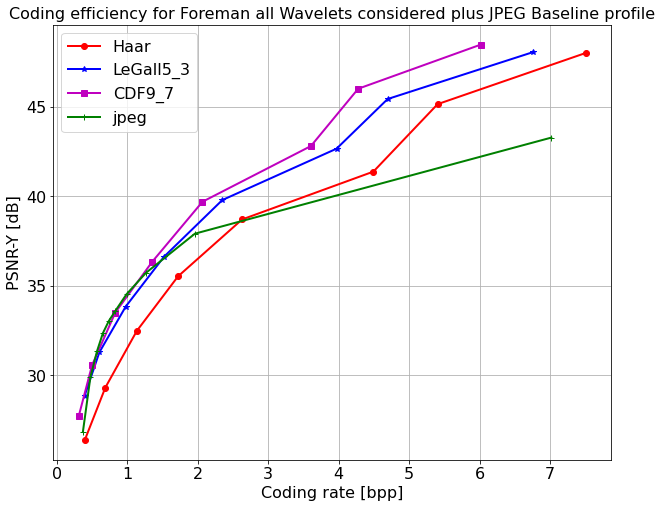

In [26]:
import matplotlib.pyplot as plt

bpp_jpeg = np.load("bpp_jpeg.npy")
psnr_jpeg = np.load("psnr_jpeg.npy")

plt.figure(figsize=(10, 8))

colours = ["r-o", "b-*", "m-s"]
for wt_idx, wt in enumerate(wavelet_type):
    plt.plot(bpp[:, wt_idx], psnr_y[:, wt_idx], colours[wt_idx], linewidth=2, label=str(wt))

plt.plot(bpp_jpeg, psnr_jpeg, "g-+", linewidth=2, label="jpeg")

plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.legend(fontsize=fsize)
plt.grid()
plt.title("Coding efficiency for Foreman all Wavelets considered plus JPEG Baseline profile", fontsize=fsize)
plt.xlabel("Coding rate [bpp]", fontsize=fsize)
plt.ylabel("PSNR-Y [dB]", fontsize=fsize);

The plot above shows two interesting facts. First off, the SWIC compression format when not using the Haar Wavelet leads to a coding efficiency which is comparable with the one of a more thoughtfully designed and refined algorithm such as the JPEG compression standard. We recall that the SWIC format specifies a simple and somewhat not fully efficient entropy encoding mechanism. Probably the superior transform used by SWIC compensates the less efficient entropy coding scheme specified. Second, a codec compliant with the SWIC format spans a wider range of coding rates, which may be useful in high fidelity compression applications. In fact, for coding rates larger than 2 bpp, JPEG struggles to provide PSNR values higher than the SWIC, notwithstanding that lower PSNR at those operating rate would not necessarily translate into a noticeable image quality difference. Finally, another obvious observation is that the SWIC format using the Haar Wavelet is far behind JPEG in terms of coding efficiency, although its implementation is simpler than the DCT (even if fast Fourier transform algorithms are used).

## Concluding remarks
In this tutorial we explored Wavelet-based image coding with focus on the transformation stage by appraising three well-known DWTs: Haar, LeGall 5/3 and CDF 9/7. To keep the tutorial self-contain and provide the reader with a code base easy to modify for further analysis and extensions we defined a minimal image compression format denoted as SWIC. In the codec specified by SWIC, we plugged the three DWTs considered and measured the rate distortion performance obtained. In line with the expectations known by those skilled in the art, a ranking among the three DWTs with respect to their coding efficiency has been established as follows (in descending order of their coding efficiency):
 * CDF 9/7
 * LeGall 5/3
 * Haar

If implementation complexity is also taken into account, then one can have a complete picture of the trade-off between coding efficiency and complexity offered by these three Wavelets. CDF 9/7 and LeGall 5/3 require additional memory access due to the use of longer filters and boundary padding. The Haar Wavelet doesn't require such an additional complexity and therefore it bears the lowest cost of implementation. We notice that the consideration about sample access for filtering and boundary padding are valid both in hardware as well as software implementations. Moreover, all the considerations made so far hold both if the user decides whether to implement the LeGall and CDF Wavelet with or without lifting. As a down side, the Haar Wavelet provides a poor coding efficiency and suffers by blocking artefacts, being effectively a block-based transform.

Still on the coding efficiency subject, we also provided the user with a qualitative explanation on why transforms having more regular scaling and Wavelet functions would result in a better coding efficiency. We also provided a pointer to a more rigorous analysis of the transform's coding efficiency based on the concept of vanishing moment. Moreover, we also compared the coding efficiency of SWIC with the JPEG compression standard in the Baseline profile to report that SWIC can be on par with such a widely known compression algorithm, yet it can offer the feature of spatial scalability. Before concluding, some aspects on how to make the SWIC format more practical and which additional features should be added are provided.

### Practical improvements
Although we designed the SWIC format by specifying code blocks for parallel entropy encoding and decoding and we used exponential Golomb Rice codes due to their simplicity, there are still a few aspects which should be added to the format to make it even more practical. These aspects may be summarised as follows.

 * **Bidirectional bitstream parsing**: Entropy encoding writes three types of information in the bitstreams. These are, the length of runs of zeros, the value which interrupts the run and its sign. In the current design this information is interleaved but if it can be spread out into dedicated segments of the bitstream, then the decoder can start the parsing of these three quantities in parallel, increasing its throughput. As an example the runs and values interrupting them can be written at the start of the code block's payload whilst the signs can be written starting from the end and proceeding backwards. At the end of the writing, the encoder will need to move the data written backwards right at the end of the segment associated with the run lengths and values interrupting each run. The decoder, which knows the payload's length, will start two parsing operations: one for the run lengths and interrupting values and another for the signs of these interrupting values, starting from the end of the payload and proceeding backwards. The idea of bidirectional parsing is also adopted in the High Throughput JPEG 2000 ([HTJ2K](https://www.htj2k.com/wp-content/uploads/white-paper.pdf)) standard, which is Part 15 of the JPEG 2000 standards family.
 * **Quantisation matrices**: As in the JPEG standard, also SWIC should support this functionality to enable a more perceptually driven compression. The support for this feature can consist in an extension of the high level syntax to define, for each decomposition level, a table of QP values to be used for each subband of that level. Two alternative approaches can also be followed here: one whereby a QP offset is transmitted and added to QP value signalled in the IPS. In a second approach some scaling values for each subband are transmitted and used as additional divisors during the quantisation process. This latter modality is the same adopted to support quantisation matrices in the H.264/AVC and H.265/HEVC standards and should allow for a finer perceptual quantisation.
 * **Tiles**: As in the JPEG 2000 standard, tiles can be defined as independently decodable portions of the image to both enable encoding on a multi processor machine (or even in a cluster of computers in the cloud) as well as to allow for image composition from different sources.
 * **Category codes**: In the current design, exponential Golomb Rice codes are also used to encode the values which interrupt the runs of zeros. These quantities are unlikely to be geometrically distributed, hence Golomb coding may not be optimal. The category codes used in the [JPEG compression standard](../jpeg/jpeg-baseline.ipynb) can also be used here to encode the minimum number of bits required to represent, without overflow, each value $v$ which interrupts a run of zeros. These minimum number of bits, $m_b$ can be coded using Huffman coding. The remainder between $v$ and $2^{m_b}$ is simply written in the bitstream with $m_b$ bits, following the same convention used in JPEG so that the sign is also signalled. Worth noting that besides the JPEG compression format, also the more recent [JPEG XS standard](https://jpeg.org/jpegxs/index.html) adopts a mechanism similar to category codes whereby the value of the most significant bit plane is Huffman encoded.

### Future directions
Besides the features discussed above to make the SWIC format even more practical, there is an additional aspect worth to explore, probably in a different tutorial. This consists in adding quality scalability to the bitstream specified by the SWIC format. Quality scalability provides a bitstream which, for any given decomposition level can be decoded at different levels of quality. Quality scalability (sometimes also referred as fine grain scalability) used to be a hot topic of research and a desired feature in image and video codec at the end of the ninenties and beginning 2000, when transmission networks were still not reliable as nowadays. Currently the types of scalability which still make sense are spatial and temporal (this latter of course for video coding). Literature has different proposals for efficient entropy encoding which guarantees quality scalability. Two noteworthy methods are the Embedded Zerotree Wavelet ([EZW](https://citeseerx.ist.psu.edu/doc/10.1.1.131.5757)) and the Set Partitioning HIerarchical Trees ([SPHIT](https://www.researchgate.net/publication/2835826_A_New_Fast_and_Efficient_Image_Codec_Based_on_Set_Partitioning_in_Hierarchical_Trees)).